In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))
from annnet.core.graph import Graph

/home/youssef/miniconda3/lib/python3.13/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


### Composite indexing

In [4]:

G = Graph()

G.set_vertex_key("name", "sex")

m = G.get_or_create_vertex_by_attrs(name="a", sex="man")
w = G.get_or_create_vertex_by_attrs(name="a", sex="woman")

print(m, w, m == w)   # expect two different ids, False



kv:name='a'|sex='man' kv:name='a'|sex='woman' False


In [6]:
G.set_vertex_key("name")


ValueError: Composite key conflict for ('a',): kv:name='a'|sex='man' vs kv:name='a'|sex='woman'

In [ ]:
m = G.get_or_create_vertex_by_attrs(name="a", sex="man")
w = G.get_or_create_vertex_by_attrs(name="a", sex="woman")
print(m, w, m == w)   # same id, True

### Flexible directionality

In [9]:
G = Graph()
G.set_vertex_key("name","sex")

u = G.get_or_create_vertex_by_attrs(name="a", sex="man")
v = G.get_or_create_vertex_by_attrs(name="a", sex="woman")

# Helper to read signs
def signs(G, eid):
    s,t,_ = G.edge_definitions[eid]
    col = G.edge_to_idx[eid]
    si = G.entity_to_idx[s]; ti = G.entity_to_idx[t]
    M = G._matrix
    return M.get((si,col),0), M.get((ti,col),0)

# Edge-scope policy
e = G.add_edge(u, v,
    flexible={"var":"capacity", "threshold":0.7, "scope":"edge", "above":"s->t", "tie": "undirected"},
    capacity=0.5, weight=1.0)

print("init:", signs(G,e))            # expect (-1, +1)
G.set_edge_attrs(e, capacity=0.9)
print("after:", signs(G,e))           # expect (+1, -1)




init: (-1.0, 1.0)
after: (1.0, -1.0)


In [11]:
# Vertex-scope policy
G2 = Graph()
G2.set_vertex_key("name","sex")
s = G2.get_or_create_vertex_by_attrs(name="a", sex="man")
t = G2.get_or_create_vertex_by_attrs(name="a", sex="woman")
G2.set_vertex_attrs(s, temp=10.0)
G2.set_vertex_attrs(t, temp=20.0)

e2 = G2.add_edge(s, t,
    flexible={"var":"temp","threshold":0.0,"scope":"vertex","above":"s->t","tie":"undirected"},
    weight=1.0)

print("xs<xt:", signs(G2,e2))         # (-1, +1)
G2.set_vertex_attrs(s, temp=25.0)
print("xs>xt:", signs(G2,e2))         # (+1, -1)
G2.set_vertex_attrs(t, temp=25.0)
print("tie  :", signs(G2,e2))         # since "tie":"undirected", it becomes: (+1, +1)

xs<xt: (-1.0, 1.0)
xs>xt: (1.0, -1.0)
tie  : (1.0, 1.0)


### Kivela Multilayers

In [2]:
# ---------- build a tiny Kivela multilayer graph ----------

G = Graph(directed=True)

# 1) Define aspects and elementary layers
G.set_aspects(
    aspects=["time"],
    elem_layers={"time": ["t1", "t2"]},
)

# 2) Add vertices in the base graph
for u in ["A", "B", "C"]:
    G.add_vertex(u, name = f"named {u}")

# 3) Declare vertex-layer presence (V_M)
for u in ["A", "B", "C"]:
    G.add_presence(u, ("t1",))
    G.add_presence(u, ("t2",))

# 4) Add Kivela edges (all go through incidence under the hood)

# intra edges in t1
G.add_intra_edge_nl("A", "B", ("t1",), weight=1.0)
G.add_intra_edge_nl("B", "C", ("t1",), weight=1.0)

# intra edges in t2
G.add_intra_edge_nl("A", "C", ("t2",), weight=2.0)

# inter-layer edge between A@t1 and B@t2
G.add_inter_edge_nl("A", ("t1",), "B", ("t2",), weight=0.5)

# coupling edges A: t1 <-> t2 and B: t1 <-> t2
G.add_coupling_edge_nl("A", ("t1",), ("t2",), weight=1.0)
G.add_coupling_edge_nl("B", ("t1",), ("t2",), weight=1.0)

# ---------- annotate layers and vertex-layer pairs ----------

# Elementary layer attributes, stored in G.layer_attributes
G.set_elementary_layer_attrs("time", "t1", order=1, name="early")
G.set_elementary_layer_attrs("time", "t2", order=2, name="late")

# vertex-layer attributes, stored in _vertex_layer_attrs
G.set_vertex_layer_attrs("A", ("t1",), activity=0.2, color="blue")
G.set_vertex_layer_attrs("A", ("t2",), activity=0.9, color="red")
G.set_vertex_layer_attrs("B", ("t1",), activity=0.5)
G.set_vertex_layer_attrs("B", ("t2",), activity=0.7)

print("vertex-layer attrs A@t1:", G.get_vertex_layer_attrs("A", ("t1",)))
print("vertex-layer attrs A@t2:", G.get_vertex_layer_attrs("A", ("t2",)))
print()

# ---------- supra structures ----------

A_supra = G.supra_adjacency()
print("Supra adjacency shape:", A_supra.shape)
print("Supra adjacency matrix:\n", A_supra.toarray())
print()

L_comb = G.supra_laplacian(kind="comb")
L_norm = G.supra_laplacian(kind="norm")
print("Combinatorial Laplacian:\n", L_comb.toarray())
print()
print("Normalized Laplacian:\n", L_norm.toarray())
print()

print("vertex-layer index (row -> (vertex, layer_tuple)):")
for i, (u, aa) in enumerate(G._row_to_nl):
    print(f"  {i}: {u} @ {aa}")
print()

deg = G.supra_degree()
print("Supra degrees per vertex-layer row:", deg)
print()

print("Participation coefficient per vertex:", G.participation_coefficient())
print("Versatility per vertex:", G.versatility())
print()

print("Layer attribute table (Polars):")
print(G.layer_attributes)


vertex-layer attrs A@t1: {'activity': 0.2, 'color': 'blue'}
vertex-layer attrs A@t2: {'activity': 0.9, 'color': 'red'}

Supra adjacency shape: (9, 9)
Supra adjacency matrix:
 [[0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  1.  0.5 0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  2. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  1.  0.  1.  0. ]
 [0.  0.5 0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  2.  0.  0.  0.  0.  0.  0. ]]

Combinatorial Laplacian:
 [[ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   2.5 -1.   0.  -1.  -0.5  0.   0.   0. ]
 [ 0.  -1.   3.   0.   0.   0.   0.   0.  -2. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -1.   0.   0.   3.  -1.   0.  -1.   0. ]
 [ 0.  -0.5  0.   0.  -1.   1.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0.   1.   0. ]
 [ 0.   0.  -2.   0.   0.   0.   0.   0.   2. ]]

Normalized L

In [3]:
# ---------- Kivela layer algebra & slice operations ----------

aa_t1 = ("t1",)
aa_t2 = ("t2",)

print("\n=== Kivela layer vertex/edge sets ===")
print("Vertices in layer t1:", G.layer_vertex_set(aa_t1))
print("Vertices in layer t2:", G.layer_vertex_set(aa_t2))

print("Intra edges in t1:", G.layer_edge_set(aa_t1))
print("Intra edges in t2:", G.layer_edge_set(aa_t2))

print("Edges touching t1 (intra+inter+coupling):",
      G.layer_edge_set(aa_t1, include_inter=True, include_coupling=True))
print("Edges touching t2 (intra+inter+coupling):",
      G.layer_edge_set(aa_t2, include_inter=True, include_coupling=True))

# ---------- pure Kivela layer algebra (set-based) ----------

print("\n=== Kivela layer algebra (set view) ===")
res_union = G.layer_union([aa_t1, aa_t2])
print("Union vertices (t1 ∪ t2):", res_union["vertices"])
print("Union edges   (t1 ∪ t2):", res_union["edges"])

res_inter = G.layer_intersection([aa_t1, aa_t2])
print("Intersection vertices (t1 ∩ t2):", res_inter["vertices"])
print("Intersection edges   (t1 ∩ t2):", res_inter["edges"])

res_diff = G.layer_difference(aa_t1, aa_t2)
print("Difference vertices (t1 \\ t2):", res_diff["vertices"])
print("Difference edges   (t1 \\ t2):", res_diff["edges"])

# ---------- Kivela → slice bridge ----------

print("\n=== Slice creation from Kivela layers ===")

# single-layer slices
sid_t1 = G.create_slice_from_layer("L_t1", aa_t1)
sid_t2 = G.create_slice_from_layer("L_t2", aa_t2)

print("All slices (incl. default):", G.list_slices(include_default=True))
print("Slice L_t1 vertices:", G.get_slice_vertices(sid_t1))
print("Slice L_t1 edges   :", G.get_slice_edges(sid_t1))
print("Slice L_t2 vertices:", G.get_slice_vertices(sid_t2))
print("Slice L_t2 edges   :", G.get_slice_edges(sid_t2))

# union / intersection / difference slices
sid_union = G.create_slice_from_layer_union("L_union_t1_t2", [aa_t1, aa_t2])
sid_inter = G.create_slice_from_layer_intersection("L_inter_t1_t2", [aa_t1, aa_t2])
sid_diff  = G.create_slice_from_layer_difference("L_diff_t1_t2", aa_t1, aa_t2)

print("Slice L_union_t1_t2 vertices:", G.get_slice_vertices(sid_union))
print("Slice L_union_t1_t2 edges   :", G.get_slice_edges(sid_union))

print("Slice L_inter_t1_t2 vertices:", G.get_slice_vertices(sid_inter))
print("Slice L_inter_t1_t2 edges   :", G.get_slice_edges(sid_inter))

print("Slice L_diff_t1_t2 vertices:", G.get_slice_vertices(sid_diff))
print("Slice L_diff_t1_t2 edges   :", G.get_slice_edges(sid_diff))

# ---------- Subgraphs from Kivela layers ----------

print("\n=== Subgraphs from Kivela layers ===")

Gs_t1 = G.subgraph_from_layer_tuple(aa_t1)
Gs_t2 = G.subgraph_from_layer_tuple(aa_t2)
Gs_union = G.subgraph_from_layer_union([aa_t1, aa_t2])
Gs_diff = G.subgraph_from_layer_difference(aa_t1, aa_t2)

print("Subgraph t1 vertices:", set(Gs_t1.entity_types.keys()))
print("Subgraph t1 edges   :", set(Gs_t1.edge_definitions.keys()))

print("Subgraph t2 vertices:", set(Gs_t2.entity_types.keys()))
print("Subgraph t2 edges   :", set(Gs_t2.edge_definitions.keys()))

print("Subgraph union(t1,t2) vertices:", set(Gs_union.entity_types.keys()))
print("Subgraph union(t1,t2) edges   :", set(Gs_union.edge_definitions.keys()))

print("Subgraph t1\\t2 vertices:", set(Gs_diff.entity_types.keys()))
print("Subgraph t1\\t2 edges   :", set(Gs_diff.edge_definitions.keys()))

# ---------- Optional: test LayerManager if exposed as G.layers ----------

if hasattr(G, "layers"):
    print("\n=== LayerManager high-level API ===")
    print("All layer tuples:", G.layers.layer_tuples())
    print("vertex_set(t1):", G.layers.vertex_set(aa_t1))
    print("edge_set(t1):", G.layers.edge_set(aa_t1))

    lm_union = G.layers.union([aa_t1, aa_t2])
    print("LayerManager union vertices:", lm_union["vertices"])
    print("LayerManager union edges   :", lm_union["edges"])

    lm_sid_t1 = G.layers.to_slice(aa_t1, slice_id="LM_t1")
    print("LM_t1 slice vertices:", G.get_slice_vertices(lm_sid_t1))
    print("LM_t1 slice edges   :", G.get_slice_edges(lm_sid_t1))

    Gs_lm = G.layers.subgraph(aa_t1)
    print("LayerManager subgraph(t1) vertices:", set(Gs_lm.entity_types.keys()))
    print("LayerManager subgraph(t1) edges   :", set(Gs_lm.edge_definitions.keys()))



=== Kivela layer vertex/edge sets ===
Vertices in layer t1: {'B', 'A', 'C'}
Vertices in layer t2: {'A', 'B', 'C'}
Intra edges in t1: {'B--C@t1', 'A--B@t1'}
Intra edges in t2: {'A--C@t2'}
Edges touching t1 (intra+inter+coupling): {'B--C@t1', 'A--B@t1', 'B--B==t1~t2', 'A--A==t1~t2', 'A--B==t1~t2'}
Edges touching t2 (intra+inter+coupling): {'A--B==t1~t2', 'B--B==t1~t2', 'A--C@t2', 'A--A==t1~t2'}

=== Kivela layer algebra (set view) ===
Union vertices (t1 ∪ t2): {'A', 'C', 'B'}
Union edges   (t1 ∪ t2): {'B--C@t1', 'A--C@t2', 'A--B@t1'}
Intersection vertices (t1 ∩ t2): {'B', 'C', 'A'}
Intersection edges   (t1 ∩ t2): set()
Difference vertices (t1 \ t2): set()
Difference edges   (t1 \ t2): {'B--C@t1', 'A--B@t1'}

=== Slice creation from Kivela layers ===
All slices (incl. default): ['default', 'L_t1', 'L_t2']
Slice L_t1 vertices: {'B', 'A', 'C'}
Slice L_t1 edges   : {'B--C@t1', 'A--B@t1'}
Slice L_t2 vertices: {'A', 'B', 'C'}
Slice L_t2 edges   : {'A--C@t2'}
Slice L_union_t1_t2 vertices: {'B'

### graphtool

In [3]:
import graph_tool.all as gt

In [4]:
import os
import sys

ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

from annnet.adapters import graphtool_adapter as gtt

In [5]:
gtG, manifest = gtt.to_graphtool(G)

# reconstruct an AnnNet graph:
G2 = gtt.from_graphtool(gtG, manifest)


In [6]:
gtG

<Graph object, directed, with 3 vertices and 6 edges, 1 internal vertex property, 2 internal edge properties, at 0x7fb77f1612b0>

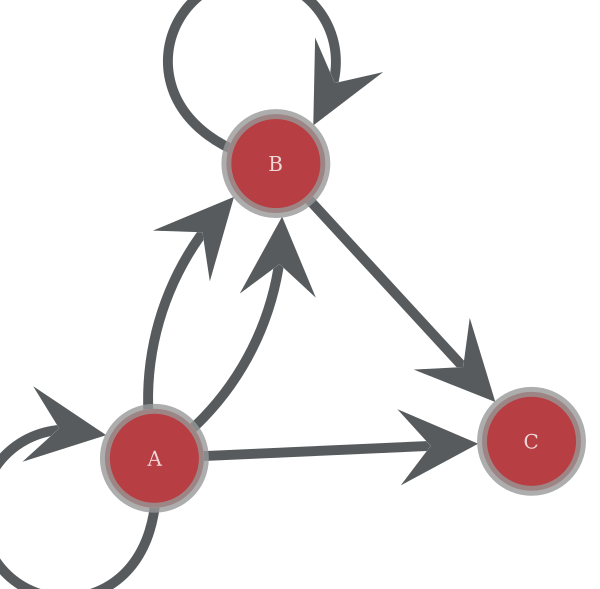

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb77f1612b0, at 0x7fb8a0ef3cd0>

In [8]:
pos = gt.sfdp_layout(gtG)

# Draw with vertex ids as labels
gt.graph_draw(
    gtG,
    pos=pos,
    vertex_text=gtG.vp["id"],
    vertex_font_size=10,
    output_size=(300,300),
)

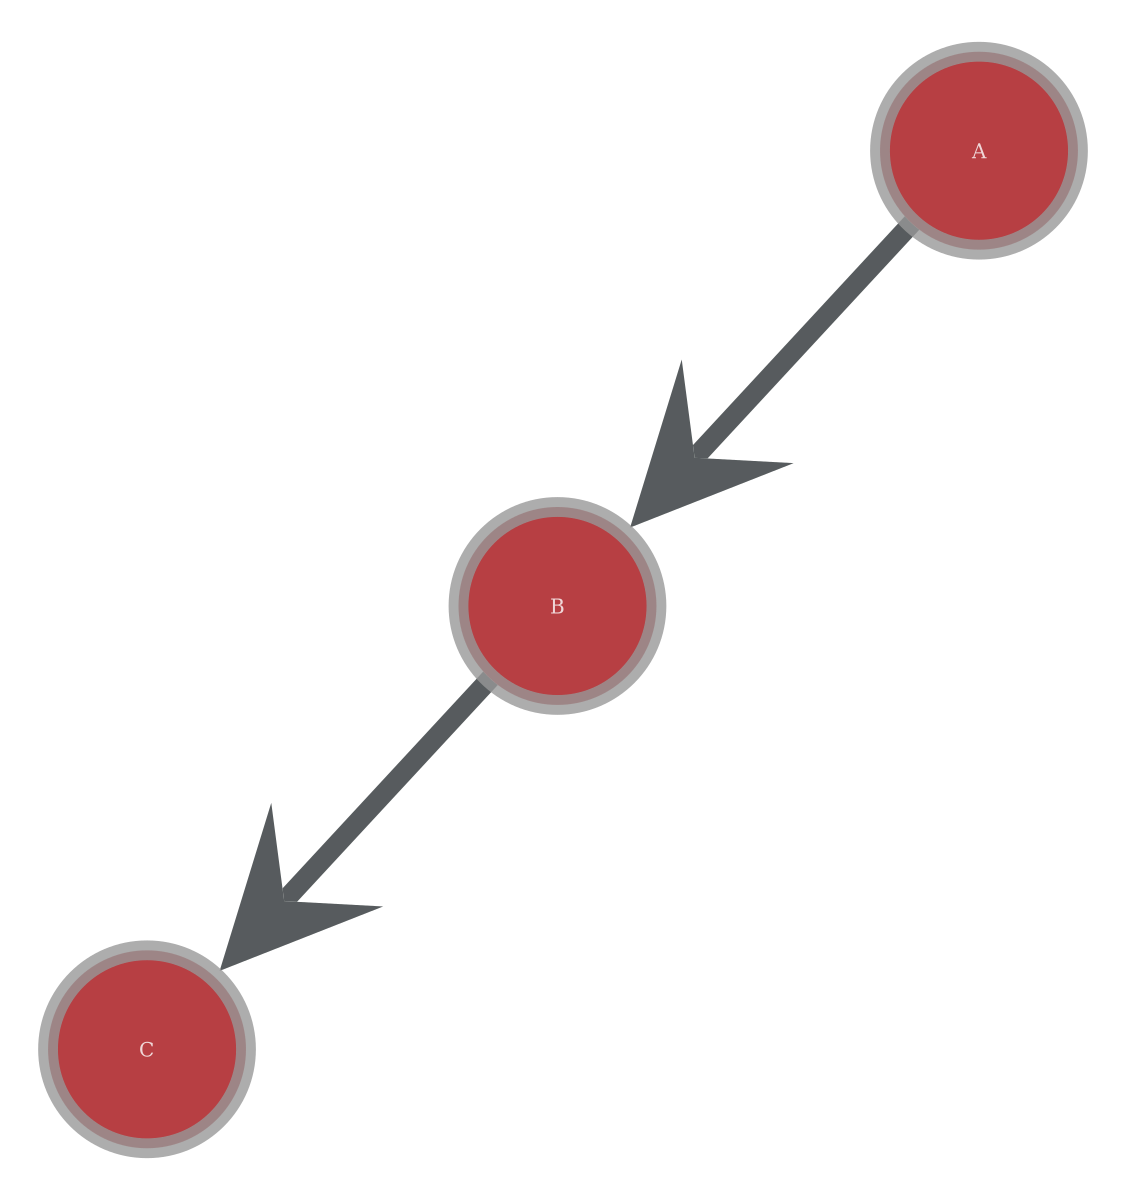

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb77f0f6850, at 0x7fb77e0fdc50>

In [9]:
# choose a layer tuple
aa = ("t1",)  # for single-aspect "time"

# subgraph of that layer
G_t1 = G.subgraph_from_layer_tuple(aa)

# project and draw
gtG_t1, man_t1 = gtt.to_graphtool(G_t1)
pos_t1 = gt.sfdp_layout(gtG_t1)
gt.graph_draw(
    gtG_t1,
    pos=pos_t1,
    vertex_text=gtG_t1.vp["id"],
    vertex_font_size=10,
    output_size=(600, 600),
)

In [10]:
manifest

{'version': 1,
 'graph': {'directed': True, 'attributes': {}},
 'vertices': {'types': {'A': 'vertex', 'B': 'vertex', 'C': 'vertex'},
  'attributes': [{'vertex_id': 'A', 'name': 'named A'},
   {'vertex_id': 'B', 'name': 'named B'},
   {'vertex_id': 'C', 'name': 'named C'}]},
 'edges': {'definitions': {'A--B@t1': ('A', 'B', 'regular'),
   'B--C@t1': ('B', 'C', 'regular'),
   'A--C@t2': ('A', 'C', 'regular'),
   'A--B==t1~t2': ('A', 'B', 'regular'),
   'A--A==t1~t2': ('A', 'A', 'regular'),
   'B--B==t1~t2': ('B', 'B', 'regular')},
  'weights': {'A--B@t1': 1.0,
   'B--C@t1': 1.0,
   'A--C@t2': 2.0,
   'A--B==t1~t2': 0.5,
   'A--A==t1~t2': 1.0,
   'B--B==t1~t2': 1.0},
  'directed': {'A--B@t1': True,
   'B--C@t1': True,
   'A--C@t2': True,
   'A--B==t1~t2': True,
   'A--A==t1~t2': True,
   'B--B==t1~t2': True},
  'direction_policy': {},
  'hyperedges': {},
  'attributes': [{'edge_id': 'A--B@t1', 'layer': 't1'},
   {'edge_id': 'B--C@t1', 'layer': 't1'},
   {'edge_id': 'A--C@t2', 'layer': 't2'